In [4]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
#transform to timestamp and add features
def AddColumns(df):
    df['Begin'] = pd.to_datetime(df['Begin'])
    #df['Date'] = pd.DatetimeIndex(df.Begin).normalize()
    df['Weekday'] = df['Begin'].dt.day_name()
    #df['Hour'] = df['Begin'].dt.hour
    df['TimeOfDay'] = df['Begin'].dt.time
    #df['Year'] = df['Begin'].dt.year
    df['Month'] = df['Begin'].dt.month_name()
    #df['Day'] = df['Begin'].dt.day
    return df


def DryHours(df):
    '''
    Input:      - df with data per pump
                - string of the pump name (to access the rain column)
    Output:     - df with only dry hours according to our definition
    '''
    dry = df[df['rain_-15_class'] == 0]
    return dry


def preprocess_df(df):
    for col in df.columns:  # go through all of the columns
        if col == "hstWaarde":  # normalize the flow column 
            df[col] = (df[col]-df[col].min())/(df[col].max()- df[col].min()) #scale between 0 and 1 using min-max normalization
    df.dropna(inplace=True)  # cleanup again... jic. Those nasty NaNs love to creep in.
    return df

# dataaaaaa

In [6]:
dataset = pd.read_csv('../../../data/new_haar.csv')
dataset.drop(['Unnamed: 0', 'datumBeginMeting'], axis=1, inplace=True) #don't need these

In [11]:
# make it only dry
dataset = DryHours(dataset)
# reset the index
dataset = dataset.reset_index()
# only select the flow 
dataset = dataset[['hstWaarde']]
dataset.head()

,hstWaarde
0,1200.0
1,260.0
2,0.0
3,0.0
4,250.0


In [13]:
dataset['hstWaarde'].value_counts()

(0.0       4338
 220.0     1080
 240.0      983
 260.0      444
 200.0      382
           ... 
 104.0        1
 350.0        1
 218.0        1
 1120.0       1
 92.0         1
 Name: hstWaarde, Length: 141, dtype: int64, 0.46856772521062867)

# use multiple timestamps as separate features

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back): # lookback = how many timestamps back do you want
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [20]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [21]:
len(train), len(test)

(6202, 3056)

In [31]:
# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [32]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((6177, 24), (6177,), (3031, 24), (3031,))

In [33]:
trainX

array([[1.        , 0.21666667, 0.        , ..., 0.2       , 0.        ,
        0.16666667],
       [0.21666667, 0.        , 0.        , ..., 0.        , 0.16666667,
        0.05      ],
       [0.        , 0.        , 0.20833333, ..., 0.16666667, 0.05      ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.2       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.2       , 0.        ,
        0.2       ],
       [0.        , 0.        , 0.18333333, ..., 0.        , 0.2       ,
        0.08333333]])

In [34]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
trainX.shape

(6177, 1, 24)

In [36]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 7s - loss: 0.0160
Epoch 2/100
 - 7s - loss: 0.0129
Epoch 3/100
 - 7s - loss: 0.0124
Epoch 4/100
 - 7s - loss: 0.0121
Epoch 5/100
 - 7s - loss: 0.0118
Epoch 6/100
 - 7s - loss: 0.0114
Epoch 7/100
 - 7s - loss: 0.0112
Epoch 8/100
 - 7s - loss: 0.0109
Epoch 9/100
 - 7s - loss: 0.0108
Epoch 10/100
 - 7s - loss: 0.0107
Epoch 11/100
 - 7s - loss: 0.0106
Epoch 12/100
 - 7s - loss: 0.0105
Epoch 13/100
 - 7s - loss: 0.0104
Epoch 14/100
 - 16s - loss: 0.0104
Epoch 15/100
 - 19s - loss: 0.0104
Epoch 16/100
 - 18s - loss: 0.0103
Epoch 17/100
 - 12s - loss: 0.0103
Epoch 18/100
 - 7s - loss: 0.0103
Epoch 19/100
 - 8s - loss: 0.0103
Epoch 20/100
 - 7s - loss: 0.0102
Epoch 21/100
 - 7s - loss: 0.0102
Epoch 22/100
 - 7s - loss: 0.0102
Epoch 23/100
 - 7s - loss: 0.0101
Epoch 24/100
 - 7s - loss: 0.0101
Epoch 25/100
 - 7s - loss: 0.0101
Epoch 26/100
 - 7s - loss: 0.0101
Epoch 27/100
 - 7s - loss: 0.0101
Epoch 28/100
 - 7s - loss: 0.0100
Epoch 29/100
 - 7s - loss: 0.0101
Epoch 30/100
 - 7s

In [37]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [38]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 114.38 RMSE
Test Score: 141.94 RMSE


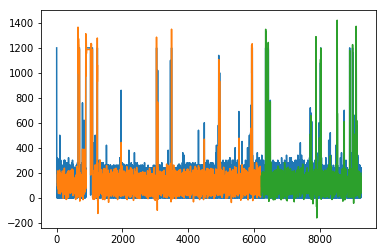

In [39]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# use multiple timestamps as one feature

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()